<a href="https://colab.research.google.com/github/tolom131/Human-Activity-Recognition/blob/main/assignment/12/assignment_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os
from torchvision.utils import make_grid

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from numpy.random import normal
from math import sqrt

## load data

In [3]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

real            = torch.from_numpy(data['real_images']).float()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## hyper-parameters

In [4]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 80
size_minibatch  = 50
dim_latent      = 64
dim_channel     = 1
learning_rate_discriminator = 0.0001
learning_rate_generator     = 0.0001

In [5]:
import random
def affine(image, shear=0, scale=1, rate=[10, 10]):

    func_plt = transforms.functional.to_pil_image
    func_affine = transforms.functional.affine
    func_tensor = transforms.functional.to_tensor

    for i in range(len(image)):

        # random movement
        if rate[0] != 0:
            rate_1 = np.random.randint(-rate[0], rate[0]+1)
            rate_2 = np.random.randint(-rate[1], rate[1]+1)
            movement = [rate_1, rate_2]
        else:
            movement = rate

        if isinstance(scale, list):
            rescale = np.random.randint(scale[0], scale[1]+1) / 10
        else:
            rescale = scale


        trans_image = func_plt(image[i])
        trans_image = func_affine(trans_image, angle=0, shear=shear, scale=rescale, translate=movement)
        trans_image = func_tensor(trans_image)
        trans_image = trans_image.numpy()

        if i == 0:
            image_list = trans_image
        else:
            image_list = np.concatenate([image_list, trans_image], axis=0)

    return image_list

In [6]:
real_image = real[::2]
affine_12 = affine(real_image, scale=[5, 12], rate=[0, 0])
affine_random = affine(real_image, scale=1, rate=[3, 3])

## custom data loader for the PyTorch framework

In [7]:
class dataset (Dataset):
    def  __init__(self, data):

        self.data = data

    def __getitem__(self, index):

        data = self.data[index]
        data = torch.FloatTensor(data).unsqueeze(dim=0)

        return data
  
    def __len__(self):
        
        return self.data.shape[0]

## construct datasets and dataloaders for training and testing

In [8]:
# image_train = np.concatenate([real[1::2], affine_12, affine_random], axis=0)
dataset_real    = dataset(real)
dataloader_real = DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

In [9]:
# image_train.shape

## shape of the data when using the data loader

In [10]:
image_real = dataset_real[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_real.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 32, 32])
*******************************************************************


## class for the neural network 

In [11]:
class Generator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=8):
        
		super(Generator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2

		self.network = nn.Sequential(
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(in_channel, dim_feature * 8, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 8),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 8, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 4),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 2),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 2, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 1),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 1, out_channel, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(out_channel),
			# ================================================================================
			nn.Sigmoid(),
			# ================================================================================
		) 			

		self.initialize_weight()
		
		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass

In [12]:
class Discriminator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=128):
        
		super(Discriminator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2
		
		self.feature = nn.Sequential(
            nn.Dropout(0.1),
			# ================================================================================
			nn.Conv2d(in_channel, dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 4, dim_feature * 8, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 8, dim_feature * 16, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
		)	
		
		self.classifier = nn.Sequential(
			# ================================================================================
			nn.Linear(dim_feature * 16, dim_feature * 8, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 8, dim_feature * 4, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 4, dim_feature * 2, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 2, dim_feature * 1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 1, out_channel, bias=True),
			# ================================================================================
		) 

		self.network = nn.Sequential(
			self.feature,
			nn.Flatten(),
			self.classifier,
		)

		self.initialize_weight()

		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass

In [13]:
generator       = Generator(dim_latent, 1, 70).to(device)
discriminator   = Discriminator(dim_channel, 1, 70).to(device)

optimizer_generator     = torch.optim.AdamW(generator.parameters(), lr=learning_rate_generator, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate_discriminator, betas=(0.5, 0.999))

initialize model parameters : xavier_uniform
initialize model parameters : xavier_uniform


## compute the prediction

In [14]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [15]:
def compute_loss_discriminator(generator, discriminator, latent, data_real):

    data_fake       = compute_prediction(generator, latent)
    prediction_real = compute_prediction(discriminator, data_real)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion   = nn.BCEWithLogitsLoss()
    
    label_real  = torch.ones_like(prediction_real)
    label_fake  = torch.zeros_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_real = criterion(prediction_real, label_real)
    loss_fake = criterion(prediction_fake, label_fake)
    # 
    # ==================================================

    loss_discriminator = (loss_real + loss_fake) / 2.0

    return loss_discriminator

In [16]:
def compute_loss_generator(generator, discriminator, latent):

    data_fake       = compute_prediction(generator, latent)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion       = nn.BCEWithLogitsLoss()

    label_real      = torch.ones_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_generator  = criterion(prediction_fake, label_real)
    # 
    # ==================================================

    return loss_generator

## compute the accuracy

In [17]:
def get_center_index(binary_image):
    
    area_square = np.sum(binary_image)

    height = binary_image.shape[0]
    width = binary_image.shape[1]

    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    indices_X, indices_Y = np.meshgrid(x, y)

    x_mean = np.sum(binary_image * indices_X) / area_square
    y_mean = np.sum(binary_image * indices_Y) / area_square

    return (x_mean, y_mean)

In [18]:
# create ideal square image which has the same area to the input image
def create_label(binary_images):
    
    label = np.zeros_like(binary_images)
    
    for i, binary_image in enumerate(binary_images):
        
        image_height = binary_image.shape[0]
        image_width = binary_image.shape[1]

        square_image = np.zeros((image_height, image_width))
        square_length = np.round(np.sqrt(np.sum(binary_image)))

        if square_length == 0:
            # when there is no square
            return square_image

        (square_center_x, square_center_y) = get_center_index(binary_image)

        if square_center_x < 0 or square_center_x > image_width - 1 or square_center_y < 0 or square_center_y > image_height - 1:
            return square_image

        top = np.ceil(square_center_y - square_length / 2)
        bottom = np.floor(square_center_y + square_length / 2)
        left = np.ceil(square_center_x - square_length / 2)
        right = np.floor(square_center_x + square_length / 2)

        top = int(top) if top >= 0 else 0
        bottom = int(bottom) if bottom <= image_height - 1 else image_height - 1
        left = int(left) if left >= 0 else 0
        right = int(right) if right <= image_width - 1 else image_width - 1

        square_image[top : bottom + 1, left : right + 1] = 1
        
        label[i] = square_image
        
    return label

In [19]:
def compute_accuracy(prediction):

    prediction  = prediction.squeeze(axis=1)
    
    prediction_binary   = (prediction >= 0.5).cpu().numpy().astype(int)
    label               = create_label(prediction_binary).astype(int)
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [20]:
loss_generator_mean     = np.zeros(number_epoch)
loss_generator_std      = np.zeros(number_epoch)
loss_discriminator_mean = np.zeros(number_epoch)
loss_discriminator_std  = np.zeros(number_epoch)

accuracy_mean   = np.zeros(number_epoch)
accuracy_std    = np.zeros(number_epoch)

## train

In [21]:
def train(generator, discriminator, dataloader):

    loss_epoch_generator      = []
    loss_epoch_discriminator  = []
    accuracy_epoch = []
    
    for index_batch, data_real in enumerate(dataloader):

        size_batch  = len(data_real)
        data_real   = data_real.to(device)
        
        latent  = torch.randn(size_batch, dim_latent, device=device)
        latent  = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()

        optimizer_generator.zero_grad()
        loss_generator = compute_loss_generator(generator, discriminator, latent)
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()

        optimizer_discriminator.zero_grad()
        loss_discriminator = compute_loss_discriminator(generator, discriminator, latent, data_real)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        data_fake   = compute_prediction(generator, latent)
        accuracy    = compute_accuracy(data_fake)

        loss_epoch_generator.append(loss_generator.item())
        loss_epoch_discriminator.append(loss_discriminator.item())
        accuracy_epoch.append(accuracy)

    loss_generator_mean_epoch       = np.mean(loss_epoch_generator)
    loss_generator_std_epoch        = np.std(loss_epoch_generator)
    
    loss_discriminator_mean_epoch   = np.mean(loss_epoch_discriminator)
    loss_discriminator_std_epoch    = np.std(loss_epoch_discriminator)

    accuracy_mean_epoch             = np.mean(accuracy_epoch)
    accuracy_std_epoch              = np.std(accuracy_epoch)

    loss_value_generator        = {'mean' : loss_generator_mean_epoch, 'std' : loss_generator_std_epoch}
    loss_value_discriminator    = {'mean' : loss_discriminator_mean_epoch, 'std' : loss_discriminator_std_epoch}
    accuracy_value              = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch} 

    return loss_value_generator, loss_value_discriminator, accuracy_value


## training epoch

In [22]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_value_generator, loss_value_discriminator, accuracy_value) = train(generator, discriminator, dataloader_real)

    loss_generator_mean[i]      = loss_value_generator['mean']
    loss_generator_std[i]       = loss_value_generator['std']

    loss_discriminator_mean[i]  = loss_value_discriminator['mean']
    loss_discriminator_std[i]   = loss_value_discriminator['std']

    accuracy_mean[i]            = accuracy_value['mean']
    accuracy_std[i]             = accuracy_value['std']

    print(f"epoch : {i}")
    print(f"\tloss_value_discriminator : {loss_value_generator['mean']}, acc mean : {accuracy_value['mean']}")

  1%|▏         | 1/80 [00:08<11:50,  8.99s/it]

epoch : 0
	loss_value_discriminator : 1.0971862561134405, acc mean : 71.5999326475257


  2%|▎         | 2/80 [00:17<11:38,  8.95s/it]

epoch : 1
	loss_value_discriminator : 2.9977066783602675, acc mean : 81.78897374299821


  4%|▍         | 3/80 [00:26<11:29,  8.95s/it]

epoch : 2
	loss_value_discriminator : 4.7225464700266375, acc mean : 75.69970736726765


  5%|▌         | 4/80 [00:35<11:20,  8.95s/it]

epoch : 3
	loss_value_discriminator : 4.308186781181153, acc mean : 78.02014336811764


  6%|▋         | 5/80 [00:44<11:11,  8.95s/it]

epoch : 4
	loss_value_discriminator : 5.300011410269627, acc mean : 79.14199279804157


  8%|▊         | 6/80 [00:53<11:01,  8.94s/it]

epoch : 5
	loss_value_discriminator : 5.446658452333882, acc mean : 79.17360786201412


  9%|▉         | 7/80 [01:02<10:52,  8.94s/it]

epoch : 6
	loss_value_discriminator : 5.41669104820074, acc mean : 78.38398796050265


 10%|█         | 8/80 [01:11<10:43,  8.94s/it]

epoch : 7
	loss_value_discriminator : 6.290578043738077, acc mean : 78.49962910238263


 11%|█▏        | 9/80 [01:20<10:34,  8.93s/it]

epoch : 8
	loss_value_discriminator : 7.292528986930847, acc mean : 82.36968310600858


 12%|█▎        | 10/80 [01:29<10:25,  8.93s/it]

epoch : 9
	loss_value_discriminator : 6.9184395102567455, acc mean : 82.83729042825948


 14%|█▍        | 11/80 [01:38<10:15,  8.92s/it]

epoch : 10
	loss_value_discriminator : 7.496974488633663, acc mean : 85.41947231424919


 15%|█▌        | 12/80 [01:47<10:06,  8.92s/it]

epoch : 11
	loss_value_discriminator : 2.14636515531429, acc mean : 74.1620461849467


 16%|█▋        | 13/80 [01:56<09:58,  8.93s/it]

epoch : 12
	loss_value_discriminator : 4.164440523053324, acc mean : 80.44406619530245


 18%|█▊        | 14/80 [02:05<09:49,  8.93s/it]

epoch : 13
	loss_value_discriminator : 5.656016244444737, acc mean : 82.52056116125287


 19%|█▉        | 15/80 [02:14<09:40,  8.93s/it]

epoch : 14
	loss_value_discriminator : 5.595186223822973, acc mean : 82.99855370304982


 20%|██        | 16/80 [02:22<09:31,  8.93s/it]

epoch : 15
	loss_value_discriminator : 5.211376825044321, acc mean : 77.5702226811958


 21%|██▏       | 17/80 [02:31<09:22,  8.93s/it]

epoch : 16
	loss_value_discriminator : 6.129494389822317, acc mean : 82.87341878799467


 22%|██▎       | 18/80 [02:40<09:13,  8.93s/it]

epoch : 17
	loss_value_discriminator : 6.9132830264956455, acc mean : 85.96566568409455


 24%|██▍       | 19/80 [02:49<09:04,  8.93s/it]

epoch : 18
	loss_value_discriminator : 6.337803735289463, acc mean : 83.97480091051737


 25%|██▌       | 20/80 [02:58<08:55,  8.93s/it]

epoch : 19
	loss_value_discriminator : 6.627383315285971, acc mean : 89.59883765734281


 26%|██▋       | 21/80 [03:07<08:46,  8.93s/it]

epoch : 20
	loss_value_discriminator : 7.254525844440904, acc mean : 91.02773377375932


 28%|██▊       | 22/80 [03:16<08:38,  8.94s/it]

epoch : 21
	loss_value_discriminator : 8.298948232517686, acc mean : 93.46543907983995


 29%|██▉       | 23/80 [03:25<08:29,  8.94s/it]

epoch : 22
	loss_value_discriminator : 7.824620895607527, acc mean : 94.65343748781171


 30%|███       | 24/80 [03:34<08:20,  8.93s/it]

epoch : 23
	loss_value_discriminator : 7.5789537707040475, acc mean : 93.60726869429853


 31%|███▏      | 25/80 [03:43<08:11,  8.93s/it]

epoch : 24
	loss_value_discriminator : 7.994682849839676, acc mean : 92.78331769916907


 32%|███▎      | 26/80 [03:52<08:02,  8.93s/it]

epoch : 25
	loss_value_discriminator : 7.820705557978431, acc mean : 91.58622539319789


 34%|███▍      | 27/80 [04:01<07:53,  8.93s/it]

epoch : 26
	loss_value_discriminator : 7.3950415932854945, acc mean : 93.61836440693772


 35%|███▌      | 28/80 [04:10<07:44,  8.93s/it]

epoch : 27
	loss_value_discriminator : 8.332039478213288, acc mean : 95.86234511452943


 36%|███▋      | 29/80 [04:19<07:35,  8.93s/it]

epoch : 28
	loss_value_discriminator : 8.710299242374509, acc mean : 90.84591532226491


 38%|███▊      | 30/80 [04:27<07:26,  8.93s/it]

epoch : 29
	loss_value_discriminator : 8.59388418530309, acc mean : 94.89029952167219


 39%|███▉      | 31/80 [04:36<07:17,  8.93s/it]

epoch : 30
	loss_value_discriminator : 8.823610716087874, acc mean : 95.8641714362289


 40%|████      | 32/80 [04:45<07:08,  8.93s/it]

epoch : 31
	loss_value_discriminator : 8.699242220368497, acc mean : 92.267096483887


 41%|████▏     | 33/80 [04:54<07:00,  8.94s/it]

epoch : 32
	loss_value_discriminator : 8.035352512847545, acc mean : 94.27921580620571


 42%|████▎     | 34/80 [05:03<06:50,  8.93s/it]

epoch : 33
	loss_value_discriminator : 6.420097989084329, acc mean : 87.35837522091957


 44%|████▍     | 35/80 [05:12<06:42,  8.94s/it]

epoch : 34
	loss_value_discriminator : 4.015456420044567, acc mean : 81.75855663750453


 45%|████▌     | 36/80 [05:21<06:33,  8.93s/it]

epoch : 35
	loss_value_discriminator : 5.245395370694094, acc mean : 87.94732429739724


 46%|████▋     | 37/80 [05:30<06:24,  8.94s/it]

epoch : 36
	loss_value_discriminator : 4.990688652493233, acc mean : 79.17894043779593


 48%|████▊     | 38/80 [05:39<06:15,  8.94s/it]

epoch : 37
	loss_value_discriminator : 4.876791341360225, acc mean : 90.36026109817763


 49%|████▉     | 39/80 [05:48<06:06,  8.93s/it]

epoch : 38
	loss_value_discriminator : 6.555501441622889, acc mean : 94.01707892766372


 50%|█████     | 40/80 [05:57<05:57,  8.93s/it]

epoch : 39
	loss_value_discriminator : 6.89006342444309, acc mean : 96.96234151080512


 51%|█████▏    | 41/80 [06:06<05:48,  8.93s/it]

epoch : 40
	loss_value_discriminator : 6.114969411561655, acc mean : 90.6340334786347


 52%|█████▎    | 42/80 [06:15<05:39,  8.94s/it]

epoch : 41
	loss_value_discriminator : 6.521553505298703, acc mean : 92.84453094113427


 54%|█████▍    | 43/80 [06:24<05:30,  8.93s/it]

epoch : 42
	loss_value_discriminator : 6.818137950675432, acc mean : 94.66413995103856


 55%|█████▌    | 44/80 [06:33<05:21,  8.93s/it]

epoch : 43
	loss_value_discriminator : 7.459064716516539, acc mean : 95.14465313023585


 56%|█████▋    | 45/80 [06:41<05:12,  8.93s/it]

epoch : 44
	loss_value_discriminator : 8.290089147035467, acc mean : 91.43422948397657


 57%|█████▊    | 46/80 [06:50<05:03,  8.93s/it]

epoch : 45
	loss_value_discriminator : 4.476578937020412, acc mean : 85.63590440612094


 59%|█████▉    | 47/80 [06:59<04:54,  8.92s/it]

epoch : 46
	loss_value_discriminator : 5.52674627858539, acc mean : 94.828707796367


 60%|██████    | 48/80 [07:08<04:45,  8.93s/it]

epoch : 47
	loss_value_discriminator : 6.846403698588526, acc mean : 95.68293023539496


 61%|██████▏   | 49/80 [07:17<04:37,  8.94s/it]

epoch : 48
	loss_value_discriminator : 6.963389044454278, acc mean : 91.35831113322278


 62%|██████▎   | 50/80 [07:26<04:28,  8.94s/it]

epoch : 49
	loss_value_discriminator : 4.8126672339993855, acc mean : 92.29212895285447


 64%|██████▍   | 51/80 [07:35<04:19,  8.93s/it]

epoch : 50
	loss_value_discriminator : 6.318052241968554, acc mean : 95.66599970409291


 65%|██████▌   | 52/80 [07:44<04:10,  8.94s/it]

epoch : 51
	loss_value_discriminator : 8.107414697491846, acc mean : 96.08752047473777


 66%|██████▋   | 53/80 [07:53<04:01,  8.94s/it]

epoch : 52
	loss_value_discriminator : 7.95787442562192, acc mean : 95.57554592608271


 68%|██████▊   | 54/80 [08:02<03:52,  8.94s/it]

epoch : 53
	loss_value_discriminator : 8.873683829640234, acc mean : 95.50726433684473


 69%|██████▉   | 55/80 [08:11<03:43,  8.94s/it]

epoch : 54
	loss_value_discriminator : 7.5686238865519675, acc mean : 95.35546649926489


 70%|███████   | 56/80 [08:20<03:34,  8.94s/it]

epoch : 55
	loss_value_discriminator : 8.508613553158073, acc mean : 95.84126796364963


 71%|███████▏  | 57/80 [08:29<03:25,  8.94s/it]

epoch : 56
	loss_value_discriminator : 8.975073038145553, acc mean : 96.75939437642495


 72%|███████▎  | 58/80 [08:38<03:16,  8.94s/it]

epoch : 57
	loss_value_discriminator : 10.321181336114574, acc mean : 95.22162704580877


 74%|███████▍  | 59/80 [08:47<03:07,  8.95s/it]

epoch : 58
	loss_value_discriminator : 7.094752533491268, acc mean : 96.53758496671708


 75%|███████▌  | 60/80 [08:56<02:58,  8.94s/it]

epoch : 59
	loss_value_discriminator : 8.67357903303102, acc mean : 95.97017097177043


 76%|███████▋  | 61/80 [09:04<02:49,  8.94s/it]

epoch : 60
	loss_value_discriminator : 9.583280757416127, acc mean : 96.35365812675731


 78%|███████▊  | 62/80 [09:13<02:40,  8.94s/it]

epoch : 61
	loss_value_discriminator : 6.488005925836259, acc mean : 91.57998716244099


 79%|███████▉  | 63/80 [09:22<02:31,  8.94s/it]

epoch : 62
	loss_value_discriminator : 5.728870369667231, acc mean : 95.63919762695235


 80%|████████  | 64/80 [09:31<02:22,  8.93s/it]

epoch : 63
	loss_value_discriminator : 7.27193941349207, acc mean : 96.08167802661082


 81%|████████▏ | 65/80 [09:40<02:13,  8.93s/it]

epoch : 64
	loss_value_discriminator : 8.05150603693585, acc mean : 96.57198261796701


 82%|████████▎ | 66/80 [09:49<02:04,  8.93s/it]

epoch : 65
	loss_value_discriminator : 8.514478528222373, acc mean : 95.44602485941972


 84%|████████▍ | 67/80 [09:58<01:56,  8.93s/it]

epoch : 66
	loss_value_discriminator : 9.36114590667015, acc mean : 95.55422232124769


 85%|████████▌ | 68/80 [10:07<01:47,  8.93s/it]

epoch : 67
	loss_value_discriminator : 10.042176424070846, acc mean : 94.89743522718018


 86%|████████▋ | 69/80 [10:16<01:38,  8.93s/it]

epoch : 68
	loss_value_discriminator : 10.39735805156619, acc mean : 95.39331046667705


 88%|████████▊ | 70/80 [10:25<01:29,  8.93s/it]

epoch : 69
	loss_value_discriminator : 10.248523579087369, acc mean : 94.28117902782496


 89%|████████▉ | 71/80 [10:34<01:20,  8.92s/it]

epoch : 70
	loss_value_discriminator : 10.334166926006938, acc mean : 94.40776452862013


 90%|█████████ | 72/80 [10:43<01:11,  8.92s/it]

epoch : 71
	loss_value_discriminator : 9.422389673265283, acc mean : 93.6871330747251


 91%|█████████▏| 73/80 [10:52<01:02,  8.92s/it]

epoch : 72
	loss_value_discriminator : 4.147967840349952, acc mean : 82.71841818469414


 92%|█████████▎| 74/80 [11:01<00:53,  8.92s/it]

epoch : 73
	loss_value_discriminator : 5.180673979049505, acc mean : 93.09051828164603


 94%|█████████▍| 75/80 [11:09<00:44,  8.92s/it]

epoch : 74
	loss_value_discriminator : 6.294075979742893, acc mean : 89.89766293208994


 95%|█████████▌| 76/80 [11:18<00:35,  8.92s/it]

epoch : 75
	loss_value_discriminator : 6.57957537506902, acc mean : 96.80987651625857


 96%|█████████▋| 77/80 [11:27<00:26,  8.92s/it]

epoch : 76
	loss_value_discriminator : 7.446373041286025, acc mean : 94.97946917225113


 98%|█████████▊| 78/80 [11:36<00:17,  8.93s/it]

epoch : 77
	loss_value_discriminator : 7.166587325029595, acc mean : 96.2132508064004


 99%|█████████▉| 79/80 [11:45<00:08,  8.93s/it]

epoch : 78
	loss_value_discriminator : 7.713218661241753, acc mean : 95.59038634977773


100%|██████████| 80/80 [11:54<00:00,  8.93s/it]

epoch : 79
	loss_value_discriminator : 8.402499453966009, acc mean : 95.66940858196601


---

# functions for visualizing the results 

---

## plot curve

In [23]:
def plot_image_grid(data, nRow, nCol, filename=None):

    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))
    
    data = data.detach().cpu()

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            image   = np.squeeze(data[k], axis=0)

            axes[i, j].imshow(image, cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [24]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [25]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [26]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title, filename=None):

    fig = plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [27]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [28]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [29]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [30]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [31]:
def function_result_01():

    print('[plot examples of the real images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_real)
    step        = int(np.floor(number_data / (nRow * nCol)))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    data = dataset_real[index_data]
    data = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [32]:
def function_result_02():

    print('[plot examples of the fake images]')
    print('') 

    nRow = 8
    nCol = 6
    number_latent = nRow * nCol

    latent  = torch.randn(number_latent, dim_latent, device=device)
    latent  = torch.reshape(latent, [number_latent, dim_latent, 1, 1])

    generator.eval()

    data_fake   = generator(latent)
    filename    = 'fake_image.png'

    plot_image_grid(data_fake, nRow, nCol, filename)

In [33]:
def function_result_03():

    print('[plot the generator loss]')
    print('') 

    plot_curve_error(loss_generator_mean, loss_generator_std, 'epoch', 'loss', 'generator loss', 'loss_generator.png')

In [34]:
def function_result_04():
    
    print('[plot the discriminator loss]')
    print('') 
    
    plot_curve_error(loss_discriminator_mean, loss_discriminator_std, 'epoch', 'loss', 'discriminator loss', 'loss_discriminator.png')

In [35]:
def function_result_05():
    
    print('[plot the accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean, accuracy_std, 'epoch', 'accuracy', 'training accuracy', 'training_accuracy.png')

In [36]:
def function_result_06():
    
    print('[print the generator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_generator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [37]:
def function_result_07():
    
    print('[print the discriminator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_discriminator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [38]:
def function_result_08():
    
    print('[print the accuracy at the last 10 epochs]')
    print('') 

    data_last = get_data_last(accuracy_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [39]:
def function_result_09():
    
    print('[print the best accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean, -10)
    print('best accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the real images]



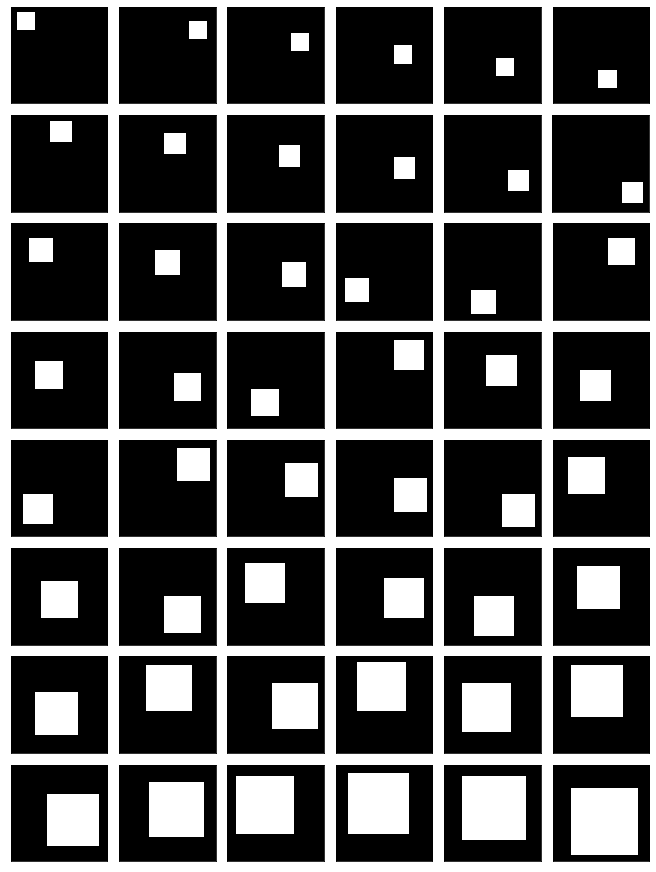


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the fake images]



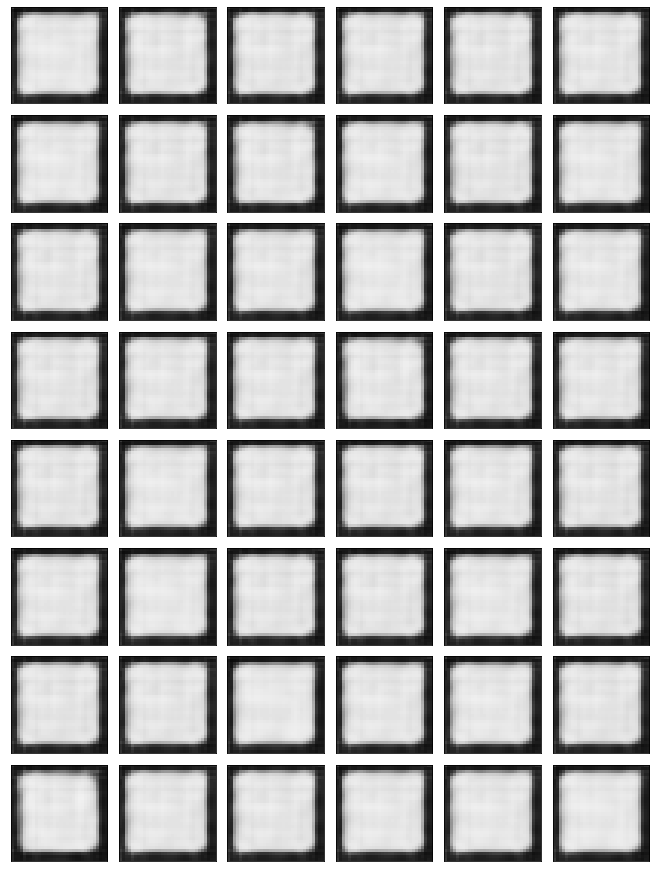


################################################################################
#
# RESULT # 03
#
################################################################################

[plot the generator loss]



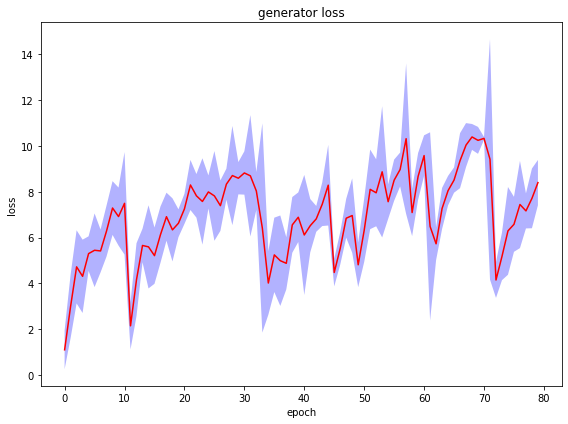


################################################################################
#
# RESULT # 04
#
################################################################################

[plot the discriminator loss]



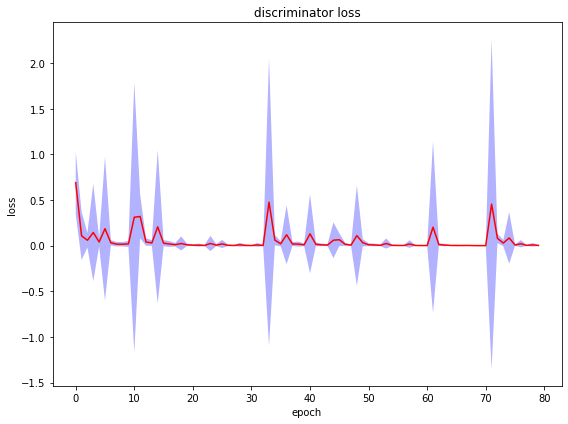


################################################################################
#
# RESULT # 05
#
################################################################################

[plot the accuracy]



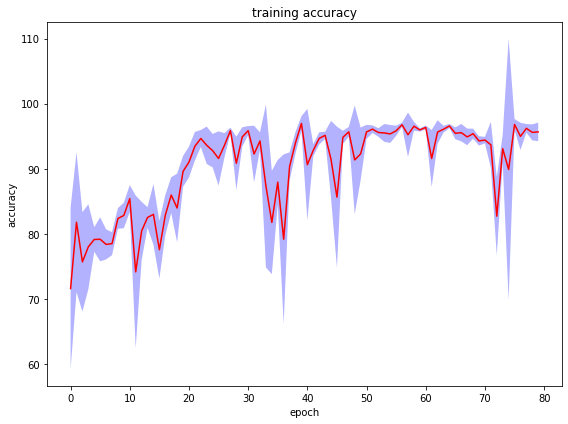


################################################################################
#
# RESULT # 06
#
################################################################################

[print the generator loss at the last 10 epochs]

index =  0, value = 10.3341669260
index =  1, value = 9.4223896733
index =  2, value = 4.1479678403
index =  3, value = 5.1806739790
index =  4, value = 6.2940759797
index =  5, value = 6.5795753751
index =  6, value = 7.4463730413
index =  7, value = 7.1665873250
index =  8, value = 7.7132186612
index =  9, value = 8.4024994540

################################################################################
#
# RESULT # 07
#
################################################################################

[print the discriminator loss at the last 10 epochs]

index =  0, value = 0.0000686401
index =  1, value = 0.4550720128
index =  2, value = 0.0797518867
index =  3, value = 0.0281248097
index =  4, value = 0.0840661491
index =  5, value = 0.0069335881
ind

In [40]:
number_result = 9

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)